# Estimating sandwich bounds on the rate-distortion function of a Gaussian source

This notebook demonstrates the method proposed in 

>  "Towards Empirical Sandwich Bounds on the Rate-Distortion Function"
>
>  Yibo Yang, Stephan Mandt
>
>  [https://arxiv.org/abs/2111.12166](https://arxiv.org/abs/2111.12166)

on a randomly generated 2-dimensional Gaussian distribution.
Also see [blog post](https://yiboyang.com/posts/estimating-the-rate-distortion-function-of-real-world-data-part-1/) for an introduction to the topic.

In [1]:
## Basic setup/imports

In [2]:
import numpy as np
import os
dtype = np.float32

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import utils

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

seed = 0
tf.random.set_seed(seed)

In [6]:
## We keep lambda fixed throughout the notebook; rerunning with different lamb traces out the full UB/LB
lamb = 3.0

## Create a Gaussian source with a randomly sampled location and scale vector

In [7]:
data_dim = 2
np.random.seed(seed)
loc = np.random.uniform(-0.5, 0.5, data_dim).astype(dtype)
var = np.random.uniform(0, 2, data_dim).astype(dtype)
scale = var ** 0.5
source = tfd.Normal(loc=loc, scale=scale)

## Estimate a point on the upper bound of the R-D curve, by training a VAE

In [8]:
args = {
    "encoder_units": [],
    "encoder_activation": None,
    "decoder_units": [
        10
    ],
    "decoder_activation": "leaky_relu",
    "posterior_type": "gaussian",
    "prior_type": "gmm_1",  # factorized Gaussian prior with learned mean and scale
    "maf_stacks": 0,
    "ar_activation": None,

    "batchsize": 64,
    "data_dim": data_dim,
    "latent_dim": data_dim,

    "lmbda": lamb,
    "lr": 5e-4,

    "epochs": 20,
    "seed": 0,
    "steps_per_epoch": 10000,
    "max_validation_steps": 1000,
    "nats": True,
    "rpd": False  # do not scale lambda by the source dimension
}
args = utils.get_args_as_obj(args)

import rdub_mlp
ub_model = rdub_mlp.Model.create_model(args)
ub_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=args.lr),
)


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.


In [9]:
dataset = tf.data.Dataset.from_tensors([])
dataset = dataset.repeat()
dataset = dataset.map(lambda _: source.sample(args.batchsize))

tmp_save_dir = '/tmp/rdvae'
lr_scheduler = rdub_mlp.get_lr_scheduler(args.lr, args.epochs, decay_factor=0.2)
hist = ub_model.fit(
    dataset.prefetch(tf.data.AUTOTUNE),
    epochs=args.epochs,
    steps_per_epoch=args.steps_per_epoch,
    validation_data=None,
    validation_freq=1,
    callbacks=[
        tf.keras.callbacks.TerminateOnNaN(),
        tf.keras.callbacks.experimental.BackupAndRestore(tmp_save_dir),
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    ],
    verbose=True
)
ub_records = hist.history


Epoch 1/20
10000/10000 [==============================] - 18s 2ms/step - loss: 2.4748 - rate: 1.3163 - mse: 0.3862
Epoch 2/20
10000/10000 [==============================] - 17s 2ms/step - loss: 2.2366 - rate: 1.2343 - mse: 0.3341
Epoch 3/20
10000/10000 [==============================] - 17s 2ms/step - loss: 2.2357 - rate: 1.2341 - mse: 0.3339
Epoch 4/20
10000/10000 [==============================] - 17s 2ms/step - loss: 2.2375 - rate: 1.2366 - mse: 0.3336
Epoch 5/20
10000/10000 [==============================] - 17s 2ms/step - loss: 2.2371 - rate: 1.2355 - mse: 0.3339
Epoch 6/20
10000/10000 [==============================] - 17s 2ms/step - loss: 2.2367 - rate: 1.2354 - mse: 0.3338
Epoch 7/20
10000/10000 [==============================] - 17s 2ms/step - loss: 2.2380 - rate: 1.2362 - mse: 0.3339
Epoch 8/20
10000/10000 [==============================] - 18s 2ms/step - loss: 2.2373 - rate: 1.2361 - mse: 0.3337
Epoch 9/20
10000/10000 [==============================] - 18s 2ms/step - loss: 2

## Estimate a point on the R-D curve by running Blahut-Arimoto on the discretized source

In [10]:
N = 100000
samples = source.sample(N).numpy()
bins = 50

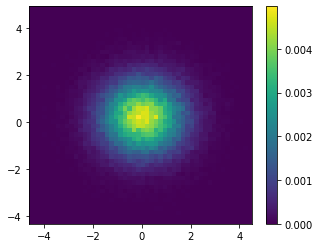

In [11]:
## Plot the discretized source
fig, ax = plt.subplots(figsize=(5, 4))
h = ax.hist2d(samples[:, 0], samples[:, 1], bins=bins, cmap='viridis', weights=np.ones(N) / N) # plot freq: https://stackoverflow.com/a/16399202
fig.colorbar(h[3], ax=ax)

In [12]:
## Get the PMF of the discretized source, and set up the discretized alphabets
from ba import bin_edges_to_grid_pts, vectorized_mse, blahut_arimoto

n = samples.shape[1]
hist_res = np.histogramdd(samples, bins=bins)  # , range=(xlim, ylim))
counts = hist_res[0]  # joint counts
bin_edges = hist_res[1]  # length-n list of arrays, each array has length bins+1

grid_axes = [bin_edges_to_grid_pts(edges) for edges in bin_edges]

# Enumerate grid points corresponding to the histogram (using the center of each bin).
meshgrid = np.meshgrid(*grid_axes, indexing='ij')  # length-n list, one 'mesh' for each data dimension
grid_pts = np.dstack(meshgrid)  # each grid point (n-tuple) resides in the inner-most dimension
grid_pts_flat = np.reshape(grid_pts, [-1, n])  # preserve the inner-most dim while flatten the rest
counts_flat = counts.ravel()


good_pts_ind = (counts_flat != 0)
src_alphabet = grid_pts_flat[good_pts_ind]  # remove bins with zero samples from the source alphabet
src_dist = counts_flat[good_pts_ind]
src_dist /= src_dist.sum()

rep_alphabet = grid_pts_flat  # use all bins from the histogram for the reproduction alphabet
Rho = vectorized_mse(src_alphabet, rep_alphabet)


In [13]:
ba_records, log_Q, log_q_y = blahut_arimoto(Rho=Rho, p_x=src_dist, steps=100, lamb=lamb, verbose=True, tol=1e-6)

{'step': 0, 'ub': 3.702002082010963, 'D': 0.33313611002238447, 'R': 2.7025937519438097}
{'step': 10, 'ub': 2.2365682997117156, 'D': 0.333159628843132, 'R': 1.2370894131823196}
{'step': 20, 'ub': 2.236505584319688, 'D': 0.33320517472767885, 'R': 1.2368900601366515}
{'step': 30, 'ub': 2.236474444165019, 'D': 0.3331970825557947, 'R': 1.2368831964976348}
Tolerance reached, terminating after 33 steps
{'step': 33, 'ub': 2.2364675408042825, 'D': 0.3331950760606714, 'R': 1.2368823126222686}


## Estimate a linear lower bound of the R-D curve, by training a neural network "-log u" function

In [14]:
from nn_models import make_mlp
lb_model = make_mlp(units=[20, 10, 1], activation='selu', name='mlp', input_shape=[data_dim])

In [15]:
def train_lb(log_u_model, nn_optimizer, train_dataset_iter, args):
    # Simplified version of rdlb.train
    records = []
    from rdlb import optimize_y, compute_Ckobj
    M = args.num_Ck_samples
    log_M = np.log(float(M))

    for step in range(-1, args.last_step):
        # Run M many global optimization runs to draw M samples of C_k, in order to estimate the training objective
        opt_ys = []
        log_Ck_samples = []
        x_M_batch = []  # a batch containing M minibatches of data samples, each minibatch consisting of k samples
        for j in range(M):  # embarrassingly parallelizable
            x = next(train_dataset_iter)
            x_M_batch.append(x)

            res = optimize_y(log_u_fun=log_u_model, x=x, lamb=args.lamb, num_steps=args.y_steps,
                             lr=args.y_lr, tol=args.y_tol, init=args.y_init,
                             quick_topn=args.y_quick_topn, verbose=False, chunksize=args.chunksize)
            opt_y = res['opt_y']
            opt_ys.append(opt_y)
            log_Ck_samples.append(res['opt_log_supobj'])

        if step == -1:  # the initial run is just to set the log expansion point alpha
            # 'log_avg_Ck' here is just the avg of the M samples of Ck in log domain, for numerical reasons
            # (and as a R.V., its expected value underestimates the true log E[C_k], just like in IWAE)
            log_avg_Ck = tf.reduce_logsumexp(log_Ck_samples) - log_M
            log_alpha = prev_log_avg_Ck = log_avg_Ck  # for next iter
            continue

        # Update log_alpha for next iter
        beta = args.beta  # should be in [0, 1)
        if abs(prev_log_avg_Ck - log_alpha) <= 10.0:  # heuristic, skips update if the new value would be too extreme
            if beta == 0:
                log_alpha = prev_log_avg_Ck
            else:  # retain beta fraction of its current value, and update alpha with (1-beta) fraction of prev_log_Ck
                # alpha = beta * alpha + (1-beta) * prev E[C_k]
                log_alpha = tf.reduce_logsumexp(
                    [log_alpha + tf.math.log(beta), prev_log_avg_Ck + tf.math.log(1 - beta)])
                
        # Estimate the RD LB objective and do gradient update
        with tf.GradientTape() as tape:
            log_Ck_samples = []
            log_us = []
            for j in tf.range(M):
                x = x_M_batch[j]
                opt_y = opt_ys[j]
                log_Ck, log_u = compute_Ckobj(log_u_fun=log_u_model, x=x, y=opt_y, lamb=lamb)
                log_Ck_samples.append(log_Ck)
                log_us.append(log_u)  # each is a length k tensor

            log_avg_Ck = tf.reduce_logsumexp(log_Ck_samples) - log_M
            log_us = tf.concat(log_us, axis=0)
            E_log_u = tf.reduce_mean(log_us)
            log_E_Ck_est = tf.math.exp(
                log_avg_Ck - log_alpha) + log_alpha - 1  # overestimator of log(E[C_k]) by linearization
            loss = E_log_u + log_E_Ck_est

        prev_log_avg_Ck = log_avg_Ck  # for next iter
        trainable_vars = log_u_model.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        nn_optimizer.apply_gradients(zip(grads, trainable_vars))
        step_rcd = dict(log_alpha=log_alpha, log_avg_Ck=log_avg_Ck, E_log_u=E_log_u,
                        log_E_Ck_est=log_E_Ck_est, loss=loss)

        print_to_console = (10 * step) % args.last_step == 0
        if print_to_console:
            str_to_print = f"step {step}:\t\tloss = {loss:.4g}, log_alpha = {log_alpha:.4g}, log_avg_Ck = {log_avg_Ck:.4g}, log_E_Ck_est = {log_E_Ck_est:.4g}, "
            str_to_print += f"E_log_u = {E_log_u:.4}"
            print(str_to_print)
        step_rcd['step'] = step

        records.append(step_rcd)

        finished = (step + 1 >= args.last_step)
        if finished:
            break
        
    return records

In [16]:
k = 1024
M = 2

In [17]:
args = {
    "data_dim": data_dim,
    "lamb": lamb,
    "batchsize": k,
    "num_Ck_samples": M,

    # for the global optimization inner loop
    "y_init": "quick",
    "y_quick_topn": 3,
    "y_steps": 1000,
    "y_tol": 1e-6,
    "y_lr": 0.01,
    "chunksize": None,

    "lr": 5e-4,
    "last_step": 400,
    "beta": 0.2,
}

args = utils.get_args_as_obj(args)

In [18]:
nn_optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)

In [19]:
dataset = tf.data.Dataset.from_tensors([])
dataset = dataset.repeat()
dataset = dataset.map(lambda _: source.sample(args.batchsize))

lb_records = train_lb(lb_model, nn_optimizer, iter(dataset), args)

step 0:		loss = -1.379, log_alpha = -1.49, log_avg_Ck = -1.474, log_E_Ck_est = -1.474, E_log_u = 0.09497
step 40:		loss = -1.538, log_alpha = -1.788, log_avg_Ck = -1.815, log_E_Ck_est = -1.814, E_log_u = 0.2759
step 80:		loss = -1.647, log_alpha = -1.999, log_avg_Ck = -2.043, log_E_Ck_est = -2.042, E_log_u = 0.3956
step 120:		loss = -1.725, log_alpha = -2.195, log_avg_Ck = -2.209, log_E_Ck_est = -2.209, E_log_u = 0.4838
step 160:		loss = -1.737, log_alpha = -2.303, log_avg_Ck = -2.317, log_E_Ck_est = -2.317, E_log_u = 0.5798
step 200:		loss = -1.762, log_alpha = -2.436, log_avg_Ck = -2.38, log_E_Ck_est = -2.379, E_log_u = 0.617
step 240:		loss = -1.845, log_alpha = -2.438, log_avg_Ck = -2.506, log_E_Ck_est = -2.503, E_log_u = 0.6581
step 280:		loss = -1.831, log_alpha = -2.538, log_avg_Ck = -2.551, log_E_Ck_est = -2.551, E_log_u = 0.7204
step 320:		loss = -1.936, log_alpha = -2.619, log_avg_Ck = -2.656, log_E_Ck_est = -2.656, E_log_u = 0.7195
step 360:		loss = -1.897, log_alpha = -2.66

In [20]:
## Run full global optimization procedure to obtain final estimate of the lower bound intercept
# (takes a while; can be parallelized)
from rdlb import est_R_
from copy import copy
test_args = copy(args)
test_args.y_init = 'exhaustive'
test_args.verbose = False
lb_result = est_R_(lb_model, lamb, iter(dataset), test_args)

## Compare the results with the ground-truth R-D function

Text(0, 0.5, 'Rate (nats per sample)')

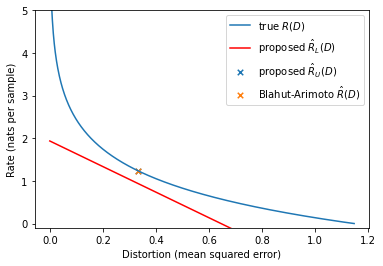

In [21]:
figsize = (6, 4)
fig = plt.figure(figsize=figsize)

gDs, gRs = utils.diag_gaussian_rdf(var, num_points=1000)
plt.plot(gDs, gRs, label='true $R(D)$')

results = {}
results['proposed $\\hat R_U(D)$'] = {'R': ub_records['rate'][-1], 'D': ub_records['mse'][-1]}
results['Blahut-Arimoto $\\hat R(D)$'] = {'R': ba_records[-1]['R'], 'D': ba_records[-1]['D']}
results['proposed $\\hat R_L(D)$'] = {'lamb': lamb, 'R_': float(lb_result['R_'])}

# plot point on the upper bound
for key, res in results.items():
    if key == 'proposed $\\hat R_L(D)$':
        xs = np.linspace(0, 0.8, 100)
        y = -res['lamb'] * xs + res['R_']  # nats
        plt.plot(xs, y, label=key, color='red')
        
    else:
        plt.scatter(res['D'], res['R'], label=key, s=30, marker='x')

# plt.xlim(0, 0.6)
plt.ylim(-0.1, 5)

plt.legend()
plt.xlabel('Distortion (mean squared error)')
plt.ylabel('Rate (nats per sample)')

In [22]:
print(results)

{'proposed $\\hat R_U(D)$': {'R': 1.234236478805542, 'D': 0.3338179588317871}, 'Blahut-Arimoto $\\hat R(D)$': {'R': 1.2368823126222686, 'D': 0.3331950760606714}, 'proposed $\\hat R_L(D)$': {'lamb': 3.0, 'R_': 1.9364495277404785}}


In [ ]:
# The points from the proposed upper bound and BA are visually indistinguishable on the plot.